In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [3]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-02-04 20:57:08--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4005:802::201b, 2404:6800:4005:809::201b, 2404:6800:4005:807::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4005:802::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv.5’

Sunspots.csv.5      100%[===================>]  69,17K   433KB/s    in 0,2s    

2024-02-04 20:57:09 (433 KB/s) - ‘Sunspots.csv.5’ saved [70827/70827]



In [4]:
# Preview the dataset
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


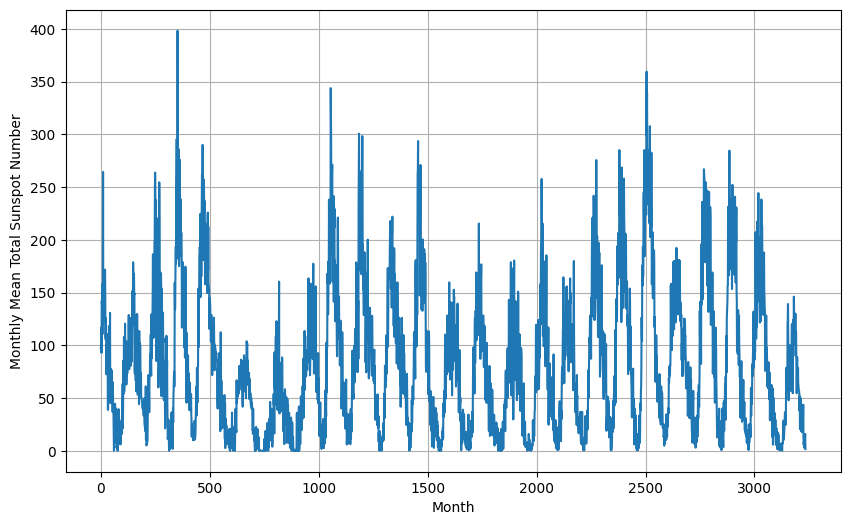

In [5]:
# Initialize lists
time_step = []
sunspots = []

# Openv CSV file
with open('./Sunspots.csv') as csvfile:
    # Initialize reader
    reader = csv.reader(csvfile, delimiter=',')
    # Skip the first line
    next(reader)
    # Append row and sunspot number to lists
    for row in reader:
        time_step.append(int(row[0]))
        sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

In [6]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [8]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-02-04 20:57:09.516489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-04 20:57:09.516637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-04 20:57:09.535796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-04 20:57:09.535937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-04 20:57:09.536037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [11]:
# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                           strides=1,
                           activation='relu',
                           padding='causal',
                           input_shape=[window_size,1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x*400)
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 64)            256       
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 30)                1950      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
 lambda_1 (Lambda)           (None, 1)                

In [12]:
# Get initial weights
init_weights = model.get_weights()

In [13]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 2s 10ms/step - loss: 78.5342 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 7ms/step - loss: 70.9187 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 6ms/step - loss: 62.5428 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 0s 4ms/step - loss: 53.5826 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 8ms/step - loss: 45.1691 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 8ms/step - loss: 38.2449 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 9ms/step - loss: 33.6660 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 1s 6ms/step - loss: 31.1767 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 8ms/step - loss: 29.8889 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 6ms/step - loss: 29.0604 - lr: 2.8184e-08
Epoch 11/100
93/93

(1e-08, 0.001, 0.0, 100.0)

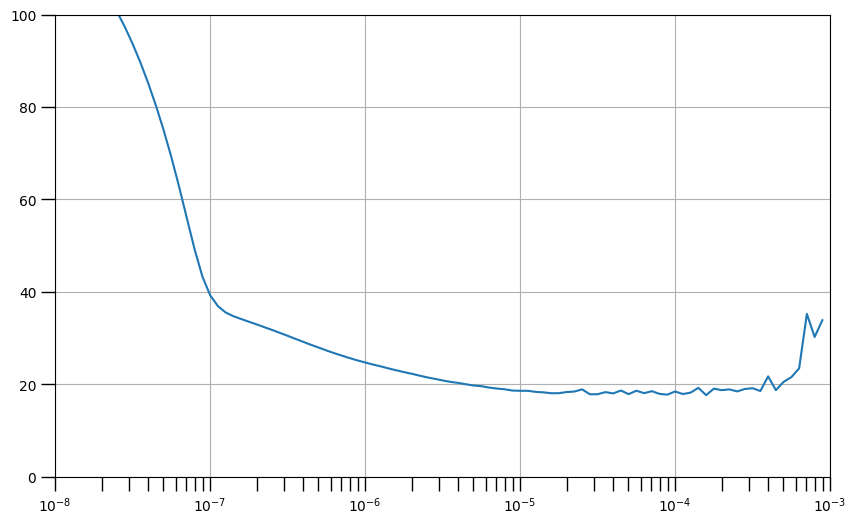

In [19]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [17]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [18]:
# Set the learning rate
learning_rate = 1e-4

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [19]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 2s 7ms/step - loss: 48.7784 - mae: 49.2752
Epoch 2/100
93/93 [==============================] - 1s 9ms/step - loss: 52.2579 - mae: 52.7558
Epoch 3/100
93/93 [==============================] - 1s 5ms/step - loss: 51.2007 - mae: 51.6981
Epoch 4/100
93/93 [==============================] - 1s 6ms/step - loss: 51.8193 - mae: 52.3165
Epoch 5/100
93/93 [==============================] - 0s 5ms/step - loss: 49.5784 - mae: 50.0766
Epoch 6/100
93/93 [==============================] - 1s 5ms/step - loss: 45.6521 - mae: 46.1497
Epoch 7/100
93/93 [==============================] - 0s 5ms/step - loss: 36.0529 - mae: 36.5479
Epoch 8/100
93/93 [==============================] - 0s 4ms/step - loss: 27.2918 - mae: 27.7871
Epoch 9/100
93/93 [==============================] - 0s 4ms/step - loss: 25.7774 - mae: 26.2730
Epoch 10/100
93/93 [==============================] - 0s 4ms/step - loss: 23.3583 - mae: 23.8539
Epoch 11/100
93/93 [===================

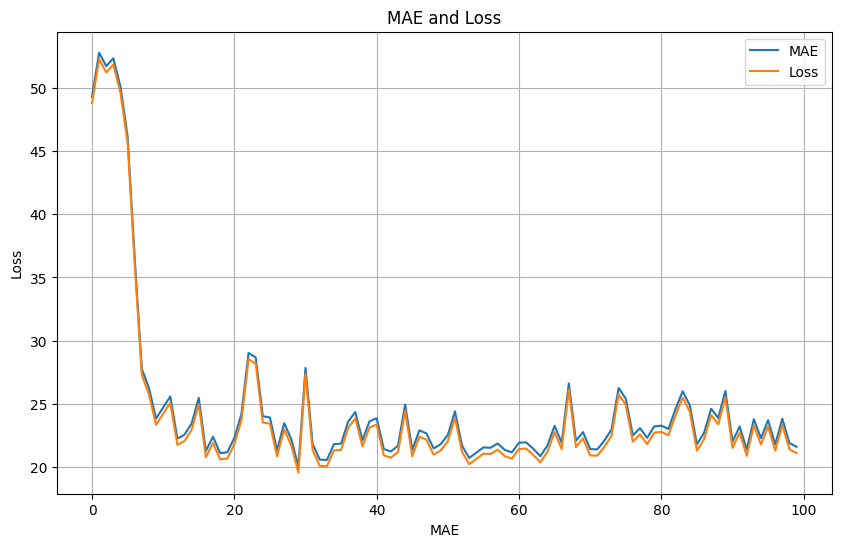

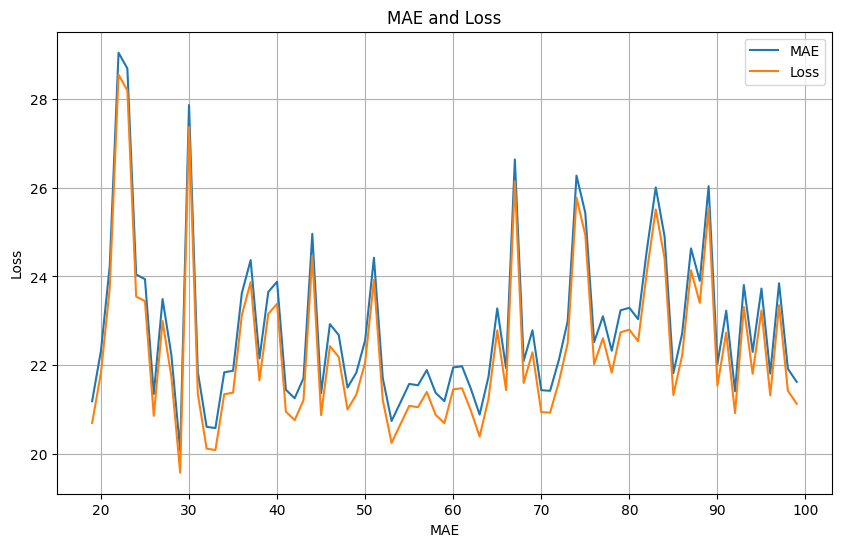

In [20]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [21]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

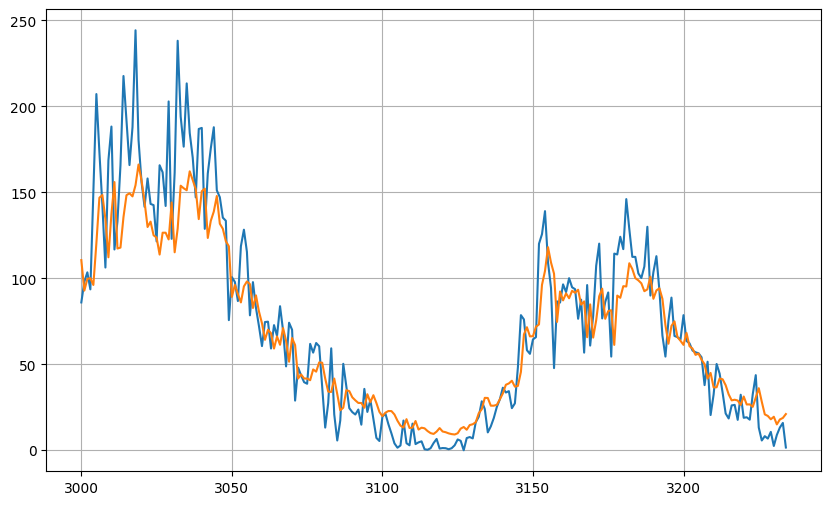

In [22]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

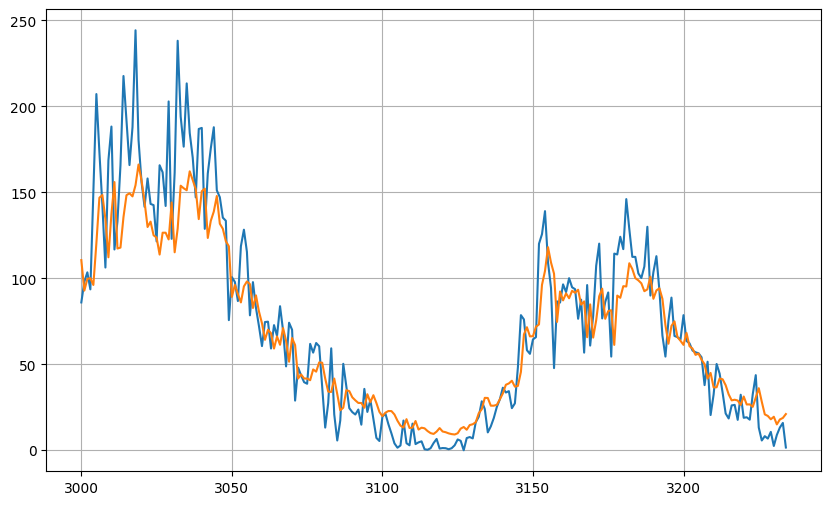

In [23]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [24]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

16.805338


## Optional

In this optional section, you will look at another way to dynamically set the learning rate. As you may have noticed, training for a long time generates less and less changes to the loss and metrics. You can run the cell below to observe that again.

In [25]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=10)

Epoch 1/10
93/93 [==============================] - 2s 11ms/step - loss: 19.6028 - mae: 20.0973
Epoch 2/10
93/93 [==============================] - 1s 9ms/step - loss: 18.7814 - mae: 19.2740
Epoch 3/10
93/93 [==============================] - 1s 10ms/step - loss: 18.3172 - mae: 18.8123
Epoch 4/10
93/93 [==============================] - 1s 6ms/step - loss: 18.0023 - mae: 18.4959
Epoch 5/10
93/93 [==============================] - 1s 8ms/step - loss: 17.7894 - mae: 18.2820
Epoch 6/10
93/93 [==============================] - 1s 11ms/step - loss: 17.6393 - mae: 18.1324
Epoch 7/10
93/93 [==============================] - 1s 10ms/step - loss: 17.5433 - mae: 18.0353
Epoch 8/10
93/93 [==============================] - 1s 9ms/step - loss: 17.4826 - mae: 17.9741
Epoch 9/10
93/93 [==============================] - 0s 4ms/step - loss: 17.4464 - mae: 17.9373
Epoch 10/10
93/93 [==============================] - 1s 6ms/step - loss: 17.4224 - mae: 17.9137


At some point, the static learning rate you set might no longer be the optimal one when the model has been learning for some time. You may want to decrease it some more to see better improvements. One way to do that is to have your training loop gradually decay the learning rate per epoch. You can pass in a lambda function similar like the one you did for the learning rate scheduler earlier, or use [ExponentialDecay()](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay). This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:

```
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

See how it is used below.

In [26]:
# Set the initial learning rate
initial_learning_rate=1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=40)

Epoch 1/40
93/93 [==============================] - 2s 9ms/step - loss: 17.4014 - mae: 17.8927
Epoch 2/40
93/93 [==============================] - 1s 7ms/step - loss: 17.3860 - mae: 17.8773
Epoch 3/40
93/93 [==============================] - 1s 8ms/step - loss: 17.3675 - mae: 17.8588
Epoch 4/40
93/93 [==============================] - 1s 7ms/step - loss: 17.3539 - mae: 17.8452
Epoch 5/40
93/93 [==============================] - 1s 6ms/step - loss: 17.3430 - mae: 17.8340
Epoch 6/40
93/93 [==============================] - 0s 3ms/step - loss: 17.3307 - mae: 17.8219
Epoch 7/40
93/93 [==============================] - 0s 4ms/step - loss: 17.3162 - mae: 17.8070
Epoch 8/40
93/93 [==============================] - 1s 5ms/step - loss: 17.3085 - mae: 17.7992
Epoch 9/40
93/93 [==============================] - 1s 7ms/step - loss: 17.2969 - mae: 17.7880
Epoch 10/40
93/93 [==============================] - 1s 7ms/step - loss: 17.2885 - mae: 17.7807
Epoch 11/40
93/93 [==============================

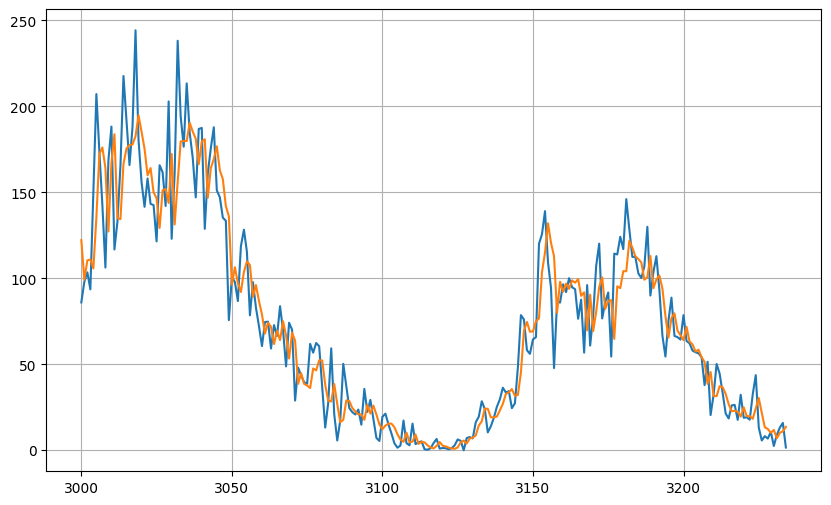

In [27]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [28]:
# Compute the MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.412344